# Линеаризация лайков

In [1]:
#Импортируем библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

#подключаемся к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator',
'user':'student',
'password':'dpo_python_2020'
}

#Задаем размер графика
sns.set(rc={'figure.figsize':(15,10)})

In [2]:
#Выгружаем нужные данные
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [3]:
df.exp_group.unique()

array([1, 3, 2, 0], dtype=int8)

In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9920,9920,9920,9920
1,10020,10020,10020,10020
2,9877,9877,9877,9877
3,10002,10002,10002,10002


In [5]:
#Посчитаем CTR в контрольной группе
𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(df[df.exp_group == 1].𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(df[df.exp_group == 1].𝑣𝑖𝑒𝑤𝑠)

In [6]:
𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙

0.2096041628394293

In [7]:
# Применим линеаризацию
df['linear_likes'] = df.likes - CTRcontrol*df.views

In [8]:
df

,exp_group,user_id,likes,views,ctr,linear_likes
0,1,18392,7,32,0.218750,0.292667
1,3,115383,12,44,0.272727,2.777417
2,3,123580,2,11,0.181818,-0.305646
3,2,131473,9,108,0.083333,-13.637250
4,2,32420,13,44,0.295455,3.777417
...,...,...,...,...,...,...
39814,0,27030,12,64,0.187500,-1.414666
39815,3,122758,20,118,0.169492,-4.733291
39816,1,132567,52,326,0.159509,-16.330957
39817,3,122190,19,65,0.292308,5.375729


Посмотрим данные "глазами".

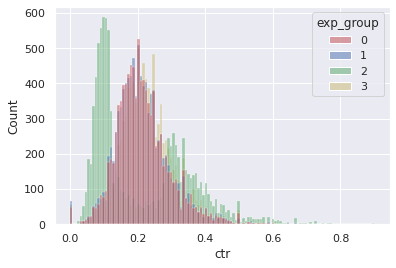

In [9]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b', 'g', 'y'],
              alpha=0.5,
              kde=False);

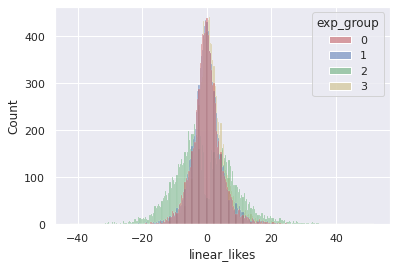

In [21]:
sns.histplot(data = df, 
              x='linear_likes', 
              hue='exp_group',
             palette = ['r', 'b', 'g', 'y'],
              alpha=0.5,
              kde=False);

Уже визуально мы видим разницу - значения после линеаризации нормализовались. Посмотрим что покажут тесты.

### Задача №1
Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

In [11]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr, 
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [12]:
stats.ttest_ind(df[df.exp_group == 0].linear_likes,
                df[df.exp_group == 3].linear_likes, 
                equal_var=False)

Ttest_indResult(statistic=-16.186621884703346, pvalue=1.482453531128053e-58)

Pvalue действительно уменьшился. В 

### Задача №2

Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

In [15]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr, 
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [14]:
stats.ttest_ind(df[df.exp_group == 1].linear_likes,
                df[df.exp_group == 2].linear_likes, 
                equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

Здесь также наблюдаем увеличение p-value. В целом, метод линеаризации метрики позволяет поднять чувствительность теста.